### SEGMENT ANYTHING MODEL (META)

https://huggingface.co/facebook/sam-vit-base

**IMPORTS**

In [1]:
# system
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../..')))

from config.path import get_training_data_path

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import torch

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

import cv2
import supervision as sv

**INSTALLS**

In [170]:
# %pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
# %pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision
# !wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P ./weights

In [2]:
CHECKPOINT_PATH = os.path.join(os.getcwd(), "weights", "sam_vit_h_4b8939.pth")
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [3]:
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    #points_per_side=20,
    pred_iou_thresh=0.96,
    #stability_score_thresh=0.98,
    #crop_n_layers=1,
    crop_n_points_downscale_factor=2,
)

In [4]:
file_name = 'tshirt_1000.png'

img_path = get_training_data_path(file_name)
image_bgr = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

masks = mask_generator.generate(image_rgb)
len(masks)

7

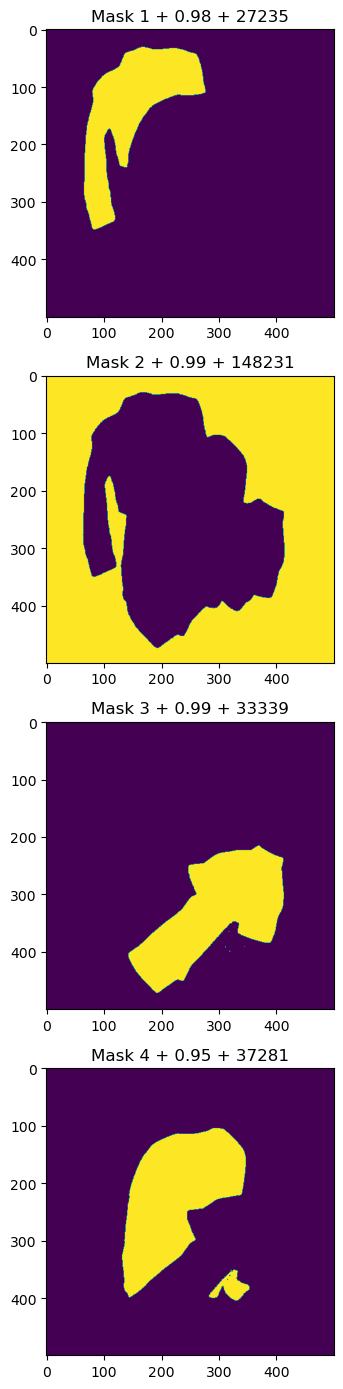

In [5]:
# Assuming masks is a list of masks
masks_greater_than_20000 = [m for m in masks if m["area"] > 20000]

fig, axes = plt.subplots(nrows=len(masks_greater_than_20000), ncols=1, figsize=(12, 14))


for i, m in enumerate(masks_greater_than_20000):
    mask = np.array(m['segmentation'], dtype=int)
    axes[i].imshow(mask)
    axes[i].set_title(f'Mask {i+1} + {masks[i]["stability_score"]:.2f} + {masks_greater_than_20000[i]["area"]}')  # Set title for each subplot

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


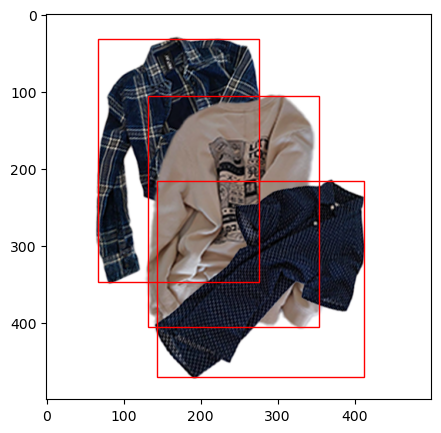

In [6]:
import matplotlib.patches as patches

def show_anns(anns):
    if len(anns) == 0:
        return

    # Sort annotations by area in descending order
    #sorted_anns = sorted(anns, key=lambda x: x['area'], reverse=True)
    sorted_anns =  [m for m in anns if m["area"] > 20000 and m["area"] < 55000]

    # Setup the plot
    ax = plt.gca()
    ax.set_autoscale_on(False)

    # Create an image array: Initialize with transparency
    # img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    # img[:, :, 3] = 0  # Set alpha channel to 0 (fully transparent)

    for ann in sorted_anns:
        # m = ann['segmentation']
        # Random color with fixed alpha
        # color_mask = np.concatenate([np.random.random(3), [0.46]])
        # img[m] = color_mask

        # Draw bounding boxes
        # Bbox format: [x_min, y_min, width, height]
        rect = patches.Rectangle((ann['bbox'][0], ann['bbox'][1]), ann['bbox'][2], ann['bbox'][3], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

plt.figure(figsize=(5,5))
plt.imshow(image_rgb)
show_anns(masks)

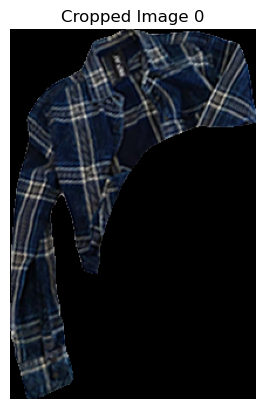

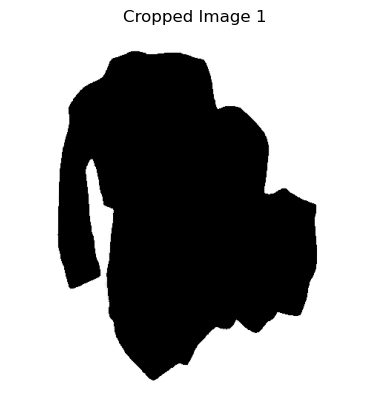

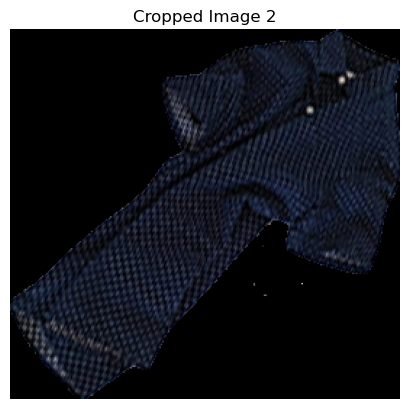

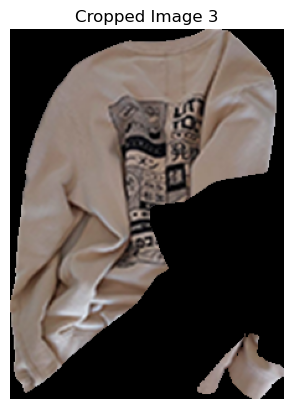

In [7]:
import cv2

# Assuming 'image' is your original image and 'annotations' is a list of dictionaries containing annotations
for i, ann in enumerate(masks_greater_than_20000):
    # Extract bounding box coordinates
    x, y, width, height = ann['bbox']
    
    # Define rectangular region
    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
    
    mask = np.array(ann['segmentation'], dtype=np.uint8)
    masked_image = cv2.bitwise_and(image_rgb, image_rgb, mask=mask)
    
    # Crop the region from the original image
    cropped_image = masked_image[y:y+height, x:x+width]

    # Save the cropped image
    output_path = f"cropped_image_{i}.jpg"
    cv2.imwrite(output_path, cropped_image)

    # Optionally, visualize the cropped region
    plt.imshow(cropped_image)
    plt.title(f"Cropped Image {i}")
    plt.axis('off')
    plt.show()

[[ 74   0 136 108]]
Current Angle: 57.92599912470595
Turned Angle: -42.07400087529405


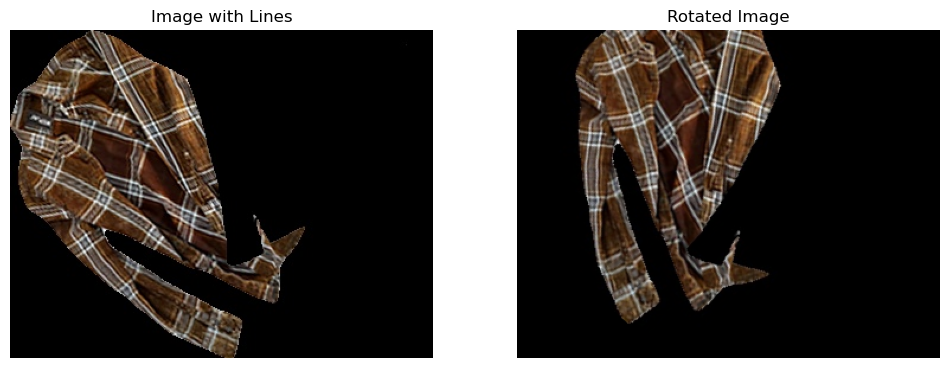

In [79]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def correct_rotation_and_display_with_lines(image_path):
    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for displaying
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Detect edges
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    # Use Hough Line Transform to detect lines
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=100, minLineLength=100, maxLineGap=10)

    print(lines[0])

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            #cv2.line(image, (x1, y1), (x2, y2), (255, 0, 0), 3)  # Draw lines in red

    # Calculate average angle of lines
    angle = np.mean([np.arctan2(y2 - y1, x2 - x1) for line[0] in lines])

    # Convert angle to degrees
    angle_degrees = angle * 180 / np.pi

    print("Current Angle: " + str(angle_degrees))

    if angle < 0:
        angle_degrees = angle_degrees + 90
    else:
        angle_degrees = -100 + angle_degrees

    
    print("Turned Angle: " + str(angle_degrees))

    # Rotate image to align
    height, width = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), angle_degrees, 1)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))

    # Display the original and rotated image using matplotlib
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.imshow(image)
    plt.title('Image with Lines')
    plt.axis('off')

    plt.subplot(122)
    plt.imshow(rotated_image)
    plt.title('Rotated Image')
    plt.axis('off')

    plt.show()


file_name = 'tshirt_0073.jpg'

img_path = get_training_data_path(file_name)
# Example usage
correct_rotation_and_display_with_lines(img_path)
